In [1]:
import json
import pathlib

import pandas as pd
import seaborn as sns

DATA_DIR = pathlib.Path('../data')

In [2]:
def load_data(filepath):
    with open(filepath) as f:
        return json.load(f)

In [3]:
def to_record(experiment):
    return {
        'board_id': experiment['gs']['boardID'],
        'ticks': experiment['gs']['tick'],
        'impossible_actions': experiment['gs']['impossibleActionCount'],
        'first_winner_tick': experiment['gs']['firstWinnerTick'],
        'heuristic': experiment['agentsParams'][0]['heuristic_method'],
    }

In [4]:
df = pd.DataFrame.from_records(to_record(x) for x in load_data(DATA_DIR / '200_ticks.json'))
df['success'] = df['ticks'] < 200
df['second_winner_lag'] = df['ticks'] - df['first_winner_tick']

## Success percentage

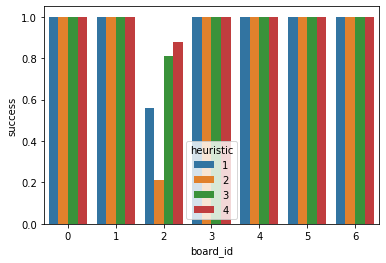

In [5]:
sns.barplot(
    y='success',
    x='board_id',
    hue='heuristic',
    data=df.groupby(['board_id', 'heuristic'])['success'].mean().reset_index(),
)

## Analysis including failures

### Ticks

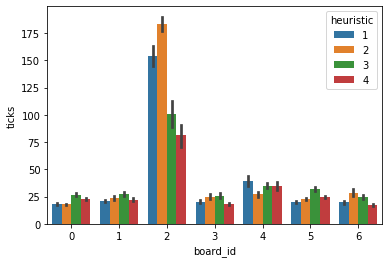

In [6]:
sns.barplot(
    y='ticks',
    x='board_id',
    hue='heuristic',
    data=df,
)

### Impossible actions

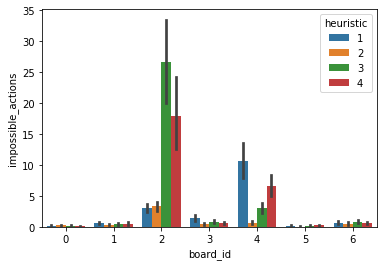

In [7]:
sns.barplot(
    y='impossible_actions',
    x='board_id',
    hue='heuristic',
    data=df,
)

### 2nd winner lag

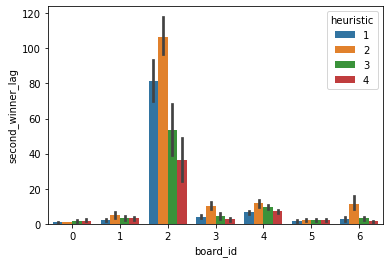

In [8]:
sns.barplot(
    y='second_winner_lag',
    x='board_id',
    hue='heuristic',
    data=df,
)

## Successfull runs only

### Ticks

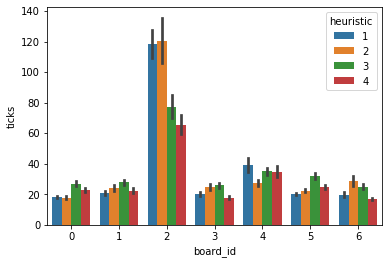

In [9]:
sns.barplot(
    y='ticks',
    x='board_id',
    hue='heuristic',
    data=df[df['success']],
)

### Impossible actions

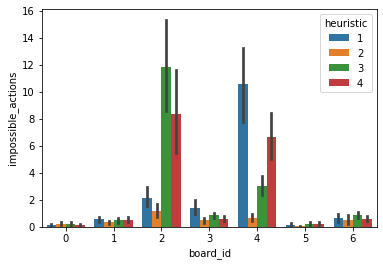

In [10]:
sns.barplot(
    y='impossible_actions',
    x='board_id',
    hue='heuristic',
    data=df[df['success']],
)

### 2nd winner lag

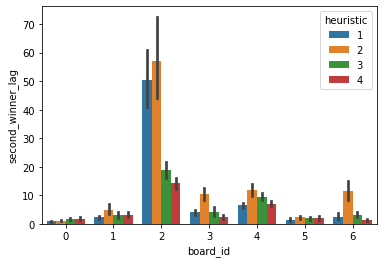

In [11]:
sns.barplot(
    y='second_winner_lag',
    x='board_id',
    hue='heuristic',
    data=df[df['success']],
)

## Pairwise everything!

Don't tell my supervisors :)

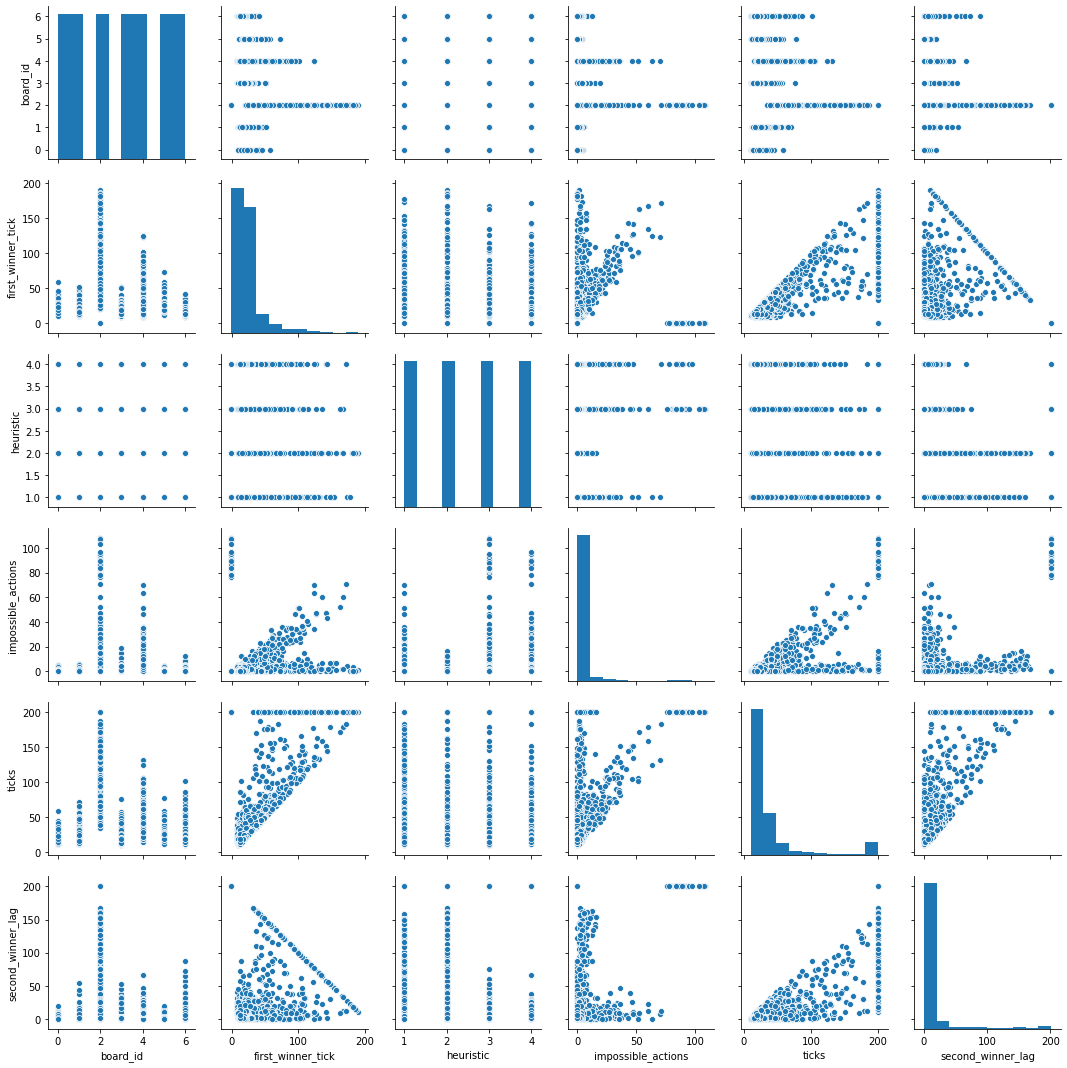

In [12]:
sns.pairplot(df.drop('success', axis=1))

In [13]:
import statsmodels.api as sm
import scipy.stats as stats

In [14]:
def column_values(df):
    data = df.values
    return [data[:, i] for i in range(df.shape[1])]

In [15]:
stats.f_oneway(
    *column_values(
        df.pivot_table(index='board_id', columns='heuristic')['success'],
    ),
)

F_onewayResult(statistic=0.4227904476695081, pvalue=0.7383681740361498)

In [16]:
df.pivot_table(index='board_id', columns='heuristic')['ticks']

heuristic,1,2,3,4
board_id,,,,
0,18.23,17.88,26.85,22.81
1,20.74,23.92,27.78,22.37
2,154.28,183.31,100.51,81.39
3,20.09,24.96,25.82,17.91
4,39.02,27.23,35.02,34.61
5,20.03,22.38,32.17,24.67
6,19.80,28.58,24.76,17.08


In [17]:
column_values(df.pivot_table(index='board_id', columns='heuristic')['ticks'])

[array([ 18.23,  20.74, 154.28,  20.09,  39.02,  20.03,  19.8 ]),
 array([ 17.88,  23.92, 183.31,  24.96,  27.23,  22.38,  28.58]),
 array([ 26.85,  27.78, 100.51,  25.82,  35.02,  32.17,  24.76]),
 array([22.81, 22.37, 81.39, 17.91, 34.61, 24.67, 17.08])]